In [1]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm, trange

/home/azhuang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_df = pd.read_csv('data/booksummaries.txt', sep='\t', names=['BookID', 'Thing', 'Title', 'Author', 'Publication Date', 'Genre', 'Summary'])
data_df = data_df.drop(columns=['Thing', 'Title', 'Author', 'Publication Date'])
data_df = data_df.dropna(ignore_index=True)
# data_df ['BookID', 'Genre', 'Summary']

In [3]:
words = []
for s in data_df['Summary']:
    words.append(len(s))
print(np.median(words))
print(sum(words) / len(data_df['Summary']))

1643.0
2598.6369441632273


In [4]:
def process_genre_list(x):
    genre_json_string = x['Genre']
    genre_list = list(json.loads(genre_json_string).values())
    genre_list = [g.lower() for g in genre_list]
    x['Genre'] = genre_list
    return x

In [5]:
data_df = data_df.apply(process_genre_list, axis=1)
data_df

,BookID,Genre,Summary
0,620,"[roman à clef, satire, children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,843,"[science fiction, novella, speculative fiction...","Alex, a teenager living in near-future Englan..."
2,986,"[existentialism, fiction, absurdist fiction, n...",The text of The Plague is divided into five p...
3,2080,"[hard science fiction, science fiction, specul...",The novel posits that space around the Milky ...
4,2152,"[war novel, roman à clef]","The book tells the story of Paul Bäumer, a Ge..."
...,...,...,...
12836,36372465,[science fiction],The story starts with former government agent...
12837,36534061,"[thriller, fiction, suspense]",The series follows the character of Nick Ston...
12838,37054020,"[thriller, fiction]",The reader first meets Rapp while he is doing...
12839,37122323,[autobiography],The book follows very rough chronological ord...


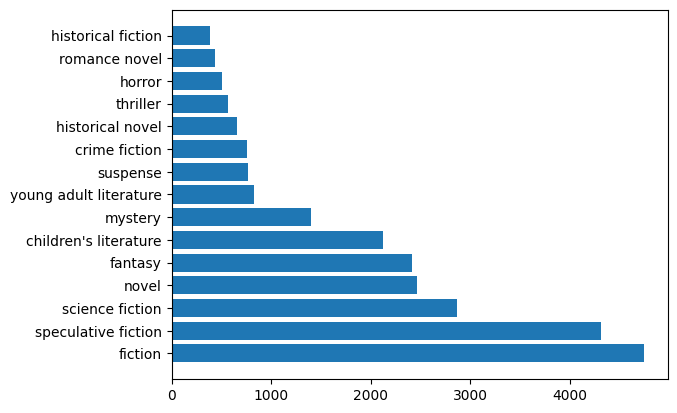

In [6]:
genres = data_df['Genre']
c = Counter()
for genre_list in genres:
    c.update(genre_list)
most_common = c.most_common(15)
items, counts = zip(*most_common)
plt.barh(items, counts)
plt.show()

In [7]:
len(c)

227

In [8]:
genres_to_find = list(items)
count = 0
for x in data_df['Genre']:
    if any(g in x for g in genres_to_find):
        count += 1
print(f"{count/len(data_df['Genre'])}, {count/len(data_df['Genre']) * len(data_df['Genre'])}")

0.9056927030605093, 11630.0


In [9]:
genre_counter = {}
for genre in genres_to_find:
    genre_counter[genre] = c[genre]

In [10]:
def filter_genres(x):
    # filter dataset to only include top 15 most common genres
    x_genres = x['Genre']
    x_genres = [g for g in x_genres if g in genre_counter]
    if len(x_genres) == 0:
        x_genres = np.nan
    x['Genre'] = x_genres
    return x

In [11]:
filtered_df = data_df.apply(filter_genres, axis=1).dropna().reset_index(drop=True)
filtered_df

,BookID,Genre,Summary
0,620,"[children's literature, speculative fiction, f...","Old Major, the old boar on the Manor Farm, ca..."
1,843,"[science fiction, speculative fiction, fiction]","Alex, a teenager living in near-future Englan..."
2,986,"[fiction, novel]",The text of The Plague is divided into five p...
3,2080,"[science fiction, speculative fiction, fantasy...",The novel posits that space around the Milky ...
4,2890,"[children's literature, fantasy, speculative f...","Ged is a young boy on Gont, one of the larger..."
...,...,...,...
11625,36126792,[young adult literature],"A novel about Annie Stonewall, the daughter o..."
11626,36372465,[science fiction],The story starts with former government agent...
11627,36534061,"[thriller, fiction, suspense]",The series follows the character of Nick Ston...
11628,37054020,"[thriller, fiction]",The reader first meets Rapp while he is doing...


In [12]:
genre_parents = {
    'fiction': [],
    'speculative fiction': ['fiction'],
    'science fiction': ['speculative fiction', 'fiction'],
    'fantasy': ['speculative fiction', 'fiction'],
    'horror': ['speculative fiction', 'fiction'],
    'novel': ['fiction'],
    'historical fiction': ['novel', 'fiction'],
    'romance novel': ['novel', 'fiction'],
    'thriller': ['novel', 'fiction'],
    'suspense': ['novel', 'fiction'],
    'crime fiction': ['novel', 'fiction'],
    'mystery': ['novel', 'fiction'],
    'young adult literature': ['novel', 'fiction'],
    "children's literature": ['novel', 'fiction'],
    'historical novel': ['novel', 'fiction']
}
genre_to_id = {
    'fiction': 0,
    'speculative fiction': 1,
    'science fiction': 2,
    'fantasy': 3,
    'horror': 4,
    'novel': 5,
    'historical fiction': 6,
    'romance novel': 7,
    'thriller': 8,
    'suspense': 9,
    'crime fiction': 10,
    'mystery': 11,
    'young adult literature': 12,
    "children's literature": 13,
    'historical novel': 14
}
id_to_genre = {v: k for k, v in genre_to_id.items()}

In [13]:
def generate_genre_vector(x):
    genre_list = x['Genre']
    genre_vector = np.zeros(len(genre_to_id))
    for genre in genre_list:
        genre_vector[genre_to_id[genre]] = 1
        for gp in genre_parents[genre]:  # mark parent genres as well
            genre_vector[genre_to_id[gp]] = 1
    x['Label'] = genre_vector
    return x

In [14]:
labeled_df = filtered_df.apply(generate_genre_vector, axis=1).reset_index(drop=True)
labeled_df

,BookID,Genre,Summary,Label
0,620,"[children's literature, speculative fiction, f...","Old Major, the old boar on the Manor Farm, ca...","[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,843,"[science fiction, speculative fiction, fiction]","Alex, a teenager living in near-future Englan...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,986,"[fiction, novel]",The text of The Plague is divided into five p...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,2080,"[science fiction, speculative fiction, fantasy...",The novel posits that space around the Milky ...,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2890,"[children's literature, fantasy, speculative f...","Ged is a young boy on Gont, one of the larger...","[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
11625,36126792,[young adult literature],"A novel about Annie Stonewall, the daughter o...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
11626,36372465,[science fiction],The story starts with former government agent...,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11627,36534061,"[thriller, fiction, suspense]",The series follows the character of Nick Ston...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
11628,37054020,"[thriller, fiction]",The reader first meets Rapp while he is doing...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."


## Create Train Test Split 80/20

In [15]:
train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42)

## Important Variables

genre_parents: genre --> list of parents

genre_to_id: genre --> id (same order as genre_parents)

labeled_df: columns = [BookID, Genre, Summary, Label] (Genre is from the original dataset while Label includes parents) 

train_df: 80% of labeled_df

test_df: 20% of labeled_df

In [16]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
num_genres = len(genre_to_id)
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=num_genres)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, num_genres),
    nn.Sigmoid()  # sigmoid activation for multi label
)

In [18]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [19]:
class SummaryDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        inputs = tokenizer(row['Summary'], return_tensors='pt', truncation=True)  # will need to collate
        input_ids = inputs['input_ids'].squeeze()
        genre_label = torch.tensor(row['Label']).float()
        return input_ids, genre_label

def collate_fn(batch):
    input_ids, labels = zip(*batch)
    pad_id = tokenizer.pad_token_id
    padded_input_ids = nn.utils.rnn.pad_sequence(
        sequences=input_ids,
        batch_first=True,
        padding_value=pad_id
    )
    attn_mask = padded_input_ids != pad_id  # 1 when not pad and 0 when pad
    labels = torch.stack([l for l in labels])
    # labels don't need to be padded bc they're all length 15
    return padded_input_ids, attn_mask, labels

In [20]:
tree_depth = max([len(parents) for parents in genre_parents.values()]) + 1
print(f"tree depth {tree_depth}")

def find_most_specific_genres(genre_vec):
    # returns the names of the most specific genres
    max_depth = 0
    most_specific = []
    for genre_id, _ in enumerate(genre_vec):
        if genre_vec[genre_id] == 0: continue
        depth = len(genre_parents[id_to_genre[genre_id]]) + 1
        if depth == max_depth:
            most_specific.append(id_to_genre[genre_id])
        elif depth > max_depth:
            max_depth = depth
            most_specific = []
            most_specific.append(id_to_genre[genre_id])
    return most_specific

def genre_distance(g1, g2, genre_parents):
    if g1 == g2: 
        return 0
    elif (g1 in genre_parents[g2]) or (g2 in genre_parents[g1]):
        return abs(len(genre_parents[g1])-len(genre_parents[g2]))
    else:
        # dist = d(g1, root) + d(g2, root) - 2*d(lca, root)
        # lca = lowest common ancestor
        lca_dist = 0
        if ("speculative fiction" in genre_parents[g1]) and ("speculative fiction" in genre_parents[g2]):
            lca_dist = 1
        elif ("novel" in genre_parents[g1]) and ("novel" in genre_parents[g2]):
            lca_dist = 1
        return len(genre_parents[g1]) + len(genre_parents[g2]) -2*lca_dist

tree depth 3


In [21]:
class HierarchicalLoss(nn.Module):
    def __init__(self, genre_parents, genre_to_id, id_to_genre, pred_threshold):
        super(HierarchicalLoss, self).__init__()
        self.genre_parents = genre_parents
        self.genre_to_id = genre_to_id
        self.id_to_genre = id_to_genre
        self.pred_threshold = pred_threshold
    
    def forward(self, predictions, targets):
        # predictions, targets shape: [batch_size, num_genres]
        # first compute binary entropy loss per summary in the batch
        base_loss = F.binary_cross_entropy_with_logits(predictions, targets, reduction='none')  # shape [batch_size, num_genres]
        per_summary_loss = base_loss.sum(dim=1)  # shape [batch_size, ]
        
        # extra loss is function of distance between prediction and closest most specific genre
        # normalized by some function of tree depth
        for i in range(base_loss.shape[0]):
            most_specific_genres = find_most_specific_genres(targets[i])
            # for all logits over the threshold (predictions), calculate extra loss
            for j in range(len(predictions[i])):
                if predictions[i][j]>=self.pred_threshold:
                    extra_loss = min(
                        [genre_distance(m, self.id_to_genre[j], self.genre_parents) for m in most_specific_genres]
                    )  # both arguments to genre_distance are strs
                    per_summary_loss[i] += extra_loss/np.sqrt(tree_depth)

        per_summary_loss /= len(self.genre_parents)  # divide by num genres to get mean per summary
        return per_summary_loss.mean()

# Training

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

lr = 1e-4
epochs = 10
batch_size = 128

train_dataloader = DataLoader(
    SummaryDataset(train_df, tokenizer),
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn
)

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
hierarchical_loss = HierarchicalLoss(genre_parents, genre_to_id, id_to_genre, pred_threshold=0.5)

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    for input_ids, attn_mask, labels in tqdm(train_dataloader, desc="inner loop", position=1):
        input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attn_mask)
        loss = hierarchical_loss(outputs.logits, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: loss {loss.item()}")
    break

using cuda


Epoch:   0%|          | 0/10 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 18.59 GiB is allocated by PyTorch, and 12.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Evaluation

In [24]:
# Always fiction

y_true = labeled_df['Label']
y_true = np.stack(y_true, axis=0)
y_pred = np.zeros_like(y_true)
y_pred[:,0] = 1
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
print(precision, recall, fscore)

1.0 0.3008355104891487 0.4625265962735389


In [29]:
# Random
precisions, recalls, fscores = [], [], []
m, n = y_true.shape
for _ in range(50):
    y_pred2 = np.zeros((m,n))
    k = np.random.randint(0, m*n)
    indices = np.random.choice(m*n, k, replace=False)
    y_pred2[np.unravel_index(indices, y_pred2.shape)] = 1
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred2, average='micro')
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
print(f"{sum(precisions)/len(precisions)}, {sum(recalls)/len(recalls)}, {sum(fscores)/len(fscores)}")


0.2216057476007001, 0.5321099873250731, 0.28458142377326034
